In [1]:
# the idea is to fit projection coefficients with NNs
# once we have built a greedy basis we fit the
# projection coefficients.
# the new step here is that we keep generating
# validation data (projection coefficients not in the reduced basis)
# to validate and train the NN without increasing the number of bases

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [2]:
import tqdm 

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

from scrinet.interfaces import lalutils

In [4]:
from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate
from scrinet.fits import nn

# Data acquisition 

We need a function that we can call to
generate data in a uniform way.We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [5]:
def gen_1d_massratio_data(q_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4_opt, inclination=0,
                          t_min=-10000, t_max=100, npts=5000
                         ):

    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        # interpolate around peak
#         max_amp_idx = amp.argmax()
#         tpeak = t[max_amp_idx]
#         t_fine = np.linspace(tpeak-10, tpeak+10,1000)
#         amp_fine = iamp(t_fine)
#         tpeak = t_fine[amp_fine.argmax()]
        
        
#         iamp = IUS(t-tpeak, amp)
#         iphase = IUS(t-tpeak, phase)
        amp = iamp(new_times)
        phase = iphase(new_times)

        
        tshift = lalutils.peak_align_shift(new_times, amp)
        amp = lalutils.peak_align_interp(new_times, amp, tshift)
        phase = lalutils.peak_align_interp(new_times, phase, tshift)

        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

# dev new surrogate class

In [6]:
"""
method outline

1. find reduced basis
2. get basis and projection coefficients
3. produce validation data by projecting new data into reduced basis
4. fit projection coefficients
"""

'\nmethod outline\n\n1. find reduced basis\n2. get basis and projection coefficients\n3. produce validation data by projecting new data into reduced basis\n4. fit projection coefficients\n'

In [7]:
class Surrogate(object):
    def __init__(self, integration):
        self.integration = integration

        self.grb = greedyrb.GreedyReducedBasis(
            integration=self.integration
        )

        pass

    def build_seed_basis(self, ts, ts_coords):
        print("building seed basis")
        self.grb.build_seed_basis(ts=ts, ts_coords=ts_coords)

    def run_greedy_sweep(self, ts, ts_coords, greedy_tol=1e-4, verbose=False):
        self.grb.greedy_sweep(ts, ts_coords, greedy_tol=greedy_tol)

    def get_basis(self):
        pass
    
    def compute_projection_coefficients(self):
        pass
    
    def alpha_dot_basis(self):
        pass
        
        
        
    def fit_eim(self, X, y,method='nn', epochs=1000, scaleX=False, scaleY=False, verbose=True, nn_outname="best", validation_data=None):
        """
        X: domain. shape = (N, M): N = number of greedy points, M = dimensionality.
            e.g., if non-spinning then M=1
        y: range. shape = (N, N)
            EIM data
        method: default = 'nn' == neural network
        epochs, scaleX, scaleY, nn_outname: only for method='nn'
        nn_outname: name of output h5 file. '.h5' get appended automatically
        """
        self.method = method
        self.scaleX = scaleX
        self.scaleY = scaleY

        fits = []

        if self.method == 'nn':
            fit = nn.RegressionANN()
            if verbose:
                print("\n====\ntraining NN\n====\n")
            history = fit.fit(
                X,
                y.T,
                input_dim=X.shape[1],
                noutput=y.shape[0],
                epochs=epochs,
                validation_data=validation_data,
                outname=nn_outname,
                scaleX=self.scaleX,
                scaleY=self.scaleY
                )
            fit.load_model(nn_outname + ".h5")
            fits.append(fit)

        if verbose:
            import matplotlib
            import matplotlib.pyplot as plt
            if self.method == 'nn':
                plt.figure()
                plt.plot(history.history['loss'], label='training loss')
                if validation_data:
                    plt.plot(history.history['val_loss'], label='validation loss')
                plt.yscale('log')
                plt.ylabel('loss')
                plt.xlabel('epochs')
                plt.show()
                plt.close()

        for i, eim_y in enumerate(y):

            if verbose:
                if self.method == 'nn':
                    yhat = fit.predict(X).T[i]

                if X.shape[1] == 1:
                    xhat = np.linspace(
                        X.min(),
                        X.max(),
                        1000)
                    if self.method == 'nn':
                        yhat_cont = fit.predict(xhat.reshape(-1,1)).T[i]
                        xhat = np.exp(xhat)
                        x2 = np.exp(X.ravel())
                    plt.figure()
                    plt.title(f"eim data [{i}]")
                    
                    xval = np.exp(validation_data[0][:,0])
                    yval = validation_data[1][:,i]
                    plt.scatter(xval, yval, label='validation')
                    
                    
                    plt.plot(xhat, yhat_cont, label='extrap', c="C1")
                    plt.scatter(x2, eim_y, label='data', s=50, c='r', lw=2)
                    plt.scatter(x2, yhat, label='fit', marker='x', s=100, lw=2, c='k')
                    plt.legend()
                    plt.show()
                    plt.close()
                else:
                    plt.figure()
                    plt.title(f"eim data [{i}]")
                    range_x = range(len(yhat))
                    plt.scatter(range_x, eim_y, label='data', s=50, c='r', lw=2)
                    plt.scatter(range_x, yhat, label='fit', marker='x', s=100, lw=2, c='k')
                    plt.legend()
                    plt.show()
                    plt.close()

        self.fits = fits

    def predict(self, coords, basis=None, log_index=0):
        """
        coords.shape = (1, M), M=dimension
        log_index: take the log of the log_index'th component.
            by default this is the 0th index.
            Use `log_index=None` to not modify the `coords`.
        """
        coords = np.array(coords)

        assert len(coords.shape) > 1, f"expected shape is (1, M) but got {coords.shape}"

        if basis is None:
            basis=self.grb.basis
        
        if log_index != None:
            coords[0,log_index] = np.log(coords[0,log_index])

        alpha = np.zeros(len(self.fits))
        
        if self.method == 'nn':
            alpha = self.fits[0].predict(coords)[0]

#         return np.dot(alpha, self.grb.eim.B)
        return np.dot(alpha, basis)

    def validate_surrogate(self, vts, vts_coords, basis=None, x=None, a=None, b=None):
        """
        vts: validation training set
            vts.shape() = (N, P)
                N = number of entries
                P = number of points e.g. length of time or frequency series
        vts_coords: validation training set coordinates / parameters
            vts_coords.shape() = (N, M).
                N = number of entries
                M = dimensionality
        x: np.ndarray of shape (P,). Default: None
        a, b: float/int. the start and end values of x for integration.
            Default: None
        """
        if basis is None:
            basis=self.grb.basis
        
        if self.method in ['nn']:
            log_index = 0

        if x is not None:
            if a is None:
                a = x[0]
            if b is None:
                b = x[-1]
            mask = (x>=a) & (x<=b)
            x = x[mask]
            integration = greedyrb.Riemann([a,b], len(x))
        else:
            integration = self.grb.integration
            # mask that is all True
            mask = np.ones(vts[0].shape).astype(np.bool)

        model_errors = np.zeros(len(vts))
        for i in range(len(vts)):
            yhat = self.predict([vts_coords[i]], basis=basis, log_index=log_index)[mask]
            y = vts[i][mask]
            # error = self.grb.integration.norm(y-yhat)**2
            error = integration.norm(y-yhat)**2
            model_errors[i] = error

        worst_error_index = np.argmax(model_errors)
        worst_case = vts_coords[worst_error_index]

        return model_errors, worst_case, worst_error_index

In [7]:
amp_or_phase = "phase"

mtotal=60
qmin=1
qmax=2
initial_qnum=2

qnpts=100

qnpts_validation=100

greedy_tol=1e-6

seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(qmin, qmax, initial_qnum), mtotal)
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

# sur = Surrogate(integration)
sur = surrogate.Surrogate(integration, basis_method='rb')


if amp_or_phase == "amp":
    seed_ts = seed_ts_amp
elif amp_or_phase == "phase":
    seed_ts = seed_ts_phase

sur.build_seed_basis(ts=seed_ts, ts_coords=seed_ts_coords)

# check seed basis and add points
_, ts_amp, ts_phase, ts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, qnpts), mtotal)

if amp_or_phase == "amp":
    ts = ts_amp
elif amp_or_phase == "phase":
    ts = ts_phase
    
sur.run_greedy_sweep(ts, ts_coords, verbose=True, greedy_tol=greedy_tol)

building seed basis
step = 0, error = 0.11903309808841502
step = 1, error = 0.07642787113936483
step = 2, error = 0.0020932428254287695
step = 3, error = 8.476244724399169e-05
step = 4, error = 7.230798595970127e-06
step = 5, error = 1.3180953423881107e-06
step = 6, error = 1.113841591160014e-06
tolerance reached. exiting


In [8]:
# get basis and projection coefficients of reduced basis
X = sur.grb.greedy_points.copy()

_, ts_amp, ts_phase, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), mtotal)
if amp_or_phase == "amp":
    ts = ts_amp
elif amp_or_phase == "phase":
    ts = ts_phase 

In [9]:
X.shape

(9, 1)

In [10]:
plt.figure()
plt.scatter(range(sur.grb.nbasis), X[:,0])
plt.xlabel("greedy number")
plt.ylabel("mass-ratio")

Text(0, 0.5, 'mass-ratio')

In [11]:
seed_x.shape

(5000,)

In [12]:
sur.grb.basis.shape

(9, 5000)

Text(0.5, 1.0, 'initial basis with 9 elements')

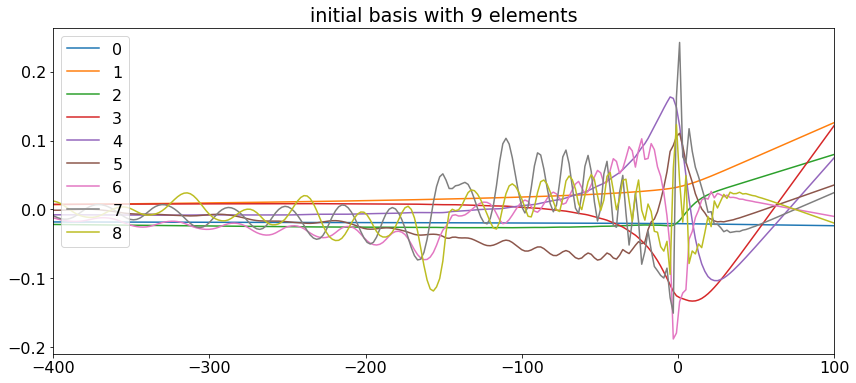

In [13]:
plt.figure(figsize=(14,6))
for i in range(sur.grb.nbasis):
    plt.plot(seed_x, sur.grb.basis[i], label=f'{i}')
plt.legend(loc='upper left')
plt.xlim(-400,100)
plt.title(f"initial basis with {sur.grb.nbasis} elements")

In [14]:
alpha_grb = sur.grb.compute_projection_coefficients_array(sur.grb.basis, ts)

In [15]:
alpha_grb.shape

(9, 9)

In [16]:
# compute validation points
# check seed basis and add points
_, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, qnpts_validation), mtotal)

if amp_or_phase == "amp":
    vts = vts_amp
elif amp_or_phase == "phase":
    vts = vts_phase
    

In [17]:
alpha1 = sur.grb.compute_projection_coefficients_array(sur.grb.basis, np.array([vts[0]]))

In [18]:
alpha1

array([[ 1.81075243e+04,  2.28767141e+01,  1.64316184e-01,
         2.50816693e-01,  4.84492128e-03, -4.08717607e-03,
         1.12484555e-03, -5.36740848e-05, -2.56296632e-04]])

In [19]:
ex1=sur.grb.compute_representation_ts(vts[0])

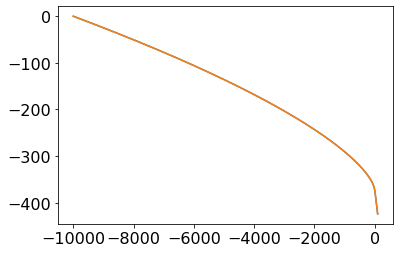

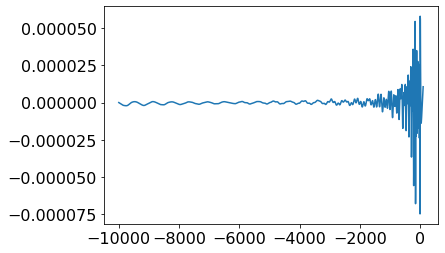

In [20]:
plt.figure()
plt.plot(x, ex1)
plt.plot(x, vts[0])

plt.figure()
plt.plot(x, ex1-vts[0])

In [21]:
alpha_val = sur.grb.compute_projection_coefficients_array(sur.grb.basis, vts)

In [22]:
alpha_val.shape

(100, 9)

In [23]:
X[:,0].shape

(9,)

In [24]:
alpha_grb.shape

(9, 9)

In [25]:
vts_coords.shape

(100, 1)

In [26]:
vts_coords[:,0]

array([1.58671415, 1.91796092, 1.25439206, 1.11161253, 1.00951776,
       1.64823335, 1.98115353, 1.0275893 , 1.37954682, 1.36847998,
       1.40118126, 1.44781886, 1.51456957, 1.68017971, 1.79944226,
       1.49231775, 1.56550702, 1.80868609, 1.48459995, 1.81343884,
       1.48877657, 1.34976567, 1.63217268, 1.3136219 , 1.15205048,
       1.2009952 , 1.67967478, 1.76124407, 1.72958938, 1.695     ,
       1.16807289, 1.38294274, 1.9181694 , 1.61413832, 1.78902227,
       1.3766913 , 1.28901083, 1.06000162, 1.00047139, 1.84880129,
       1.17746063, 1.24287571, 1.08944065, 1.27458392, 1.78104288,
       1.90000316, 1.26270177, 1.56067608, 1.35763773, 1.17652726,
       1.83605245, 1.76498607, 1.31151229, 1.74587877, 1.2309328 ,
       1.76508673, 1.43287499, 1.73673661, 1.82228026, 1.88656315,
       1.52584239, 1.82592876, 1.79344275, 1.48782796, 1.02936685,
       1.41418188, 1.1252039 , 1.18873369, 1.76045546, 1.87095798,
       1.87405656, 1.60319592, 1.22091162, 1.78003015, 1.79210

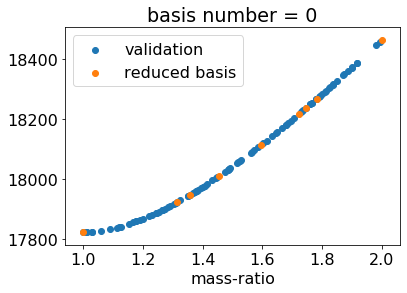

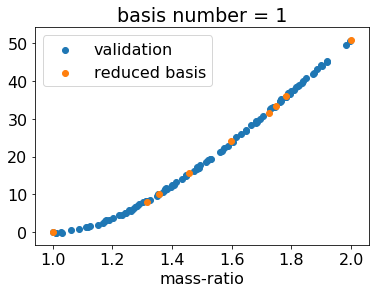

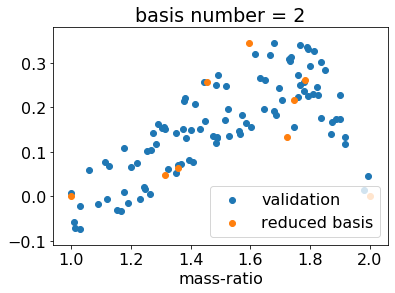

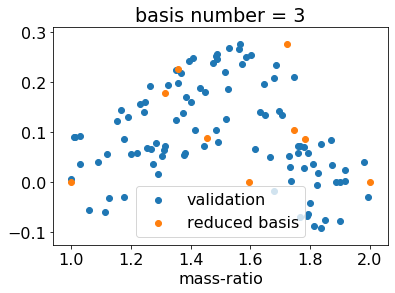

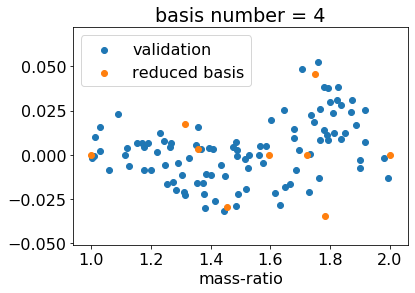

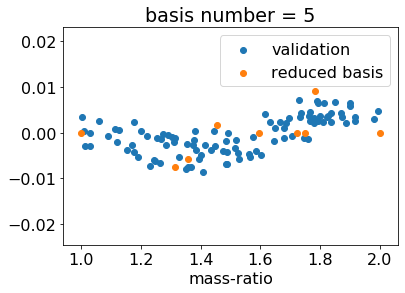

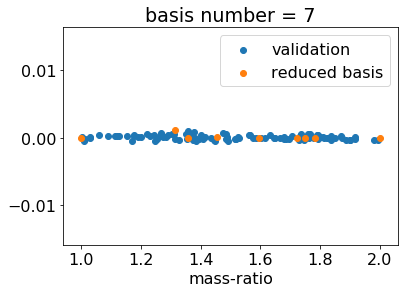

In [27]:
for i in range(sur.grb.nbasis):
    plt.figure()
    plt.scatter(vts_coords[:,0], alpha_val[:,i], label='validation')
    plt.scatter(X[:,0], alpha_grb[:,i], label='reduced basis')
    plt.legend()
    plt.xlabel("mass-ratio")
    plt.title(f'basis number = {i}')
    plt.show()
    plt.close()

# compute the basis from doing an SVD

In [29]:
# the basis cofficients are quite noisey (and therefore more difficult to fit) from the greedy reduced basis
# maybe the one from SVD is nicer

In [30]:
u, s, vh = np.linalg.svd(ts, full_matrices=False)

In [31]:
print(u.shape, s.shape, vh.shape)

(9, 9) (9,) (9, 5000)


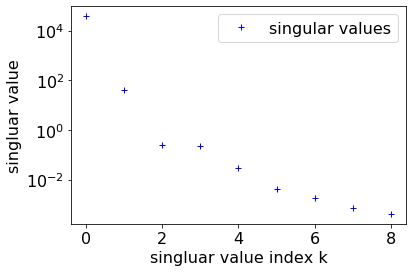

In [32]:
# From the above discussion, faster decaying singular values means the matrix/model is easier
# to compress
plt.semilogy(range(sur.grb.nbasis),s,'b+', label='singular values')
plt.ylabel('singluar value')
plt.xlabel('singluar value index k')
plt.legend(loc='best')

In [33]:
# Decide on how many column vectors to use as the basis
# basis_size = 3
# basis_size = 4
# basis_size = 5
# basis_size = 6
# basis_size = 7
basis_size=s.shape[0]
# More vectors -> more accuracy but also more computational cost 
# basis_size = -1
basis_set  = vh[0:basis_size,:]

In [34]:
def compute_projection_coeffs(RB, ref_data):
    proj_coeffs = np.array([ np.dot(RB, ref_data[i]) for i in range(len(ref_data)) ] )
    return proj_coeffs

In [35]:
proj_coeffs = compute_projection_coeffs(basis_set, ts)

In [36]:
proj_coeffs.shape

(9, 9)

In [37]:
val_proj_coeffs = compute_projection_coeffs(basis_set, vts)

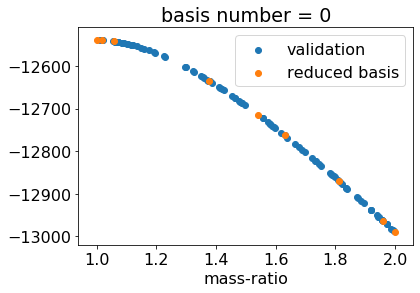

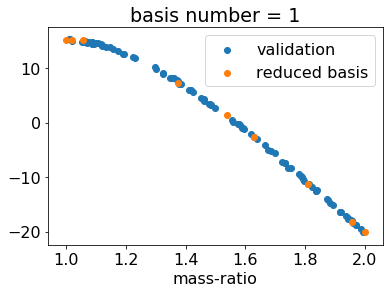

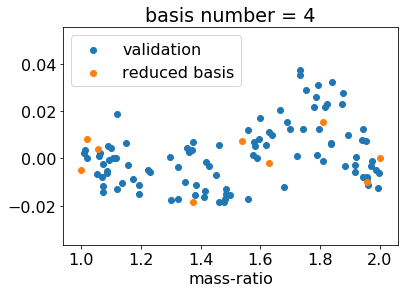

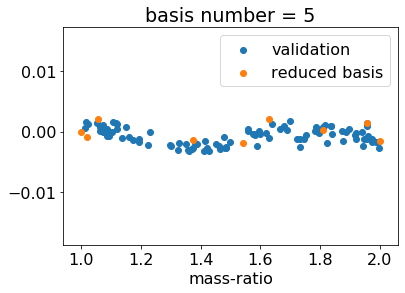

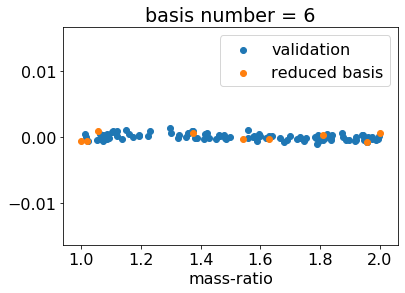

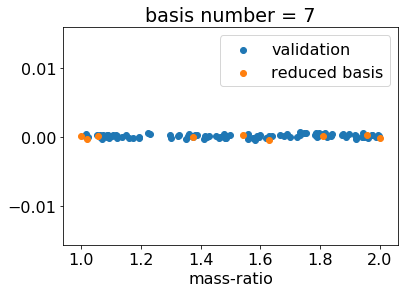

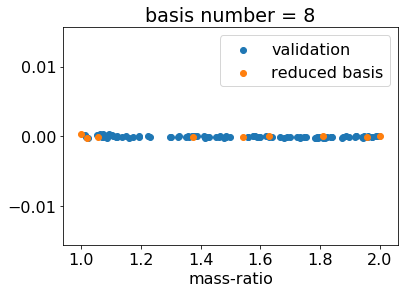

In [38]:
for i in range(proj_coeffs.shape[1]):
    plt.figure()
    plt.scatter(vts_coords[:,0], val_proj_coeffs[:,i], label='validation')
    plt.scatter(X[:,0], proj_coeffs[:,i], label='reduced basis')
    plt.legend()
    plt.xlabel("mass-ratio")
    plt.title(f'basis number = {i}')
    plt.show()
    plt.close()

# compare greedy-rb and svd bases

In [39]:
# they are similar, but have different range, some different features and also have a -1 w.r.t. eachother.

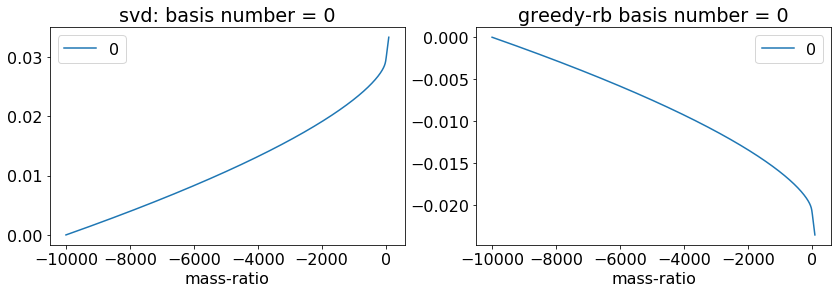

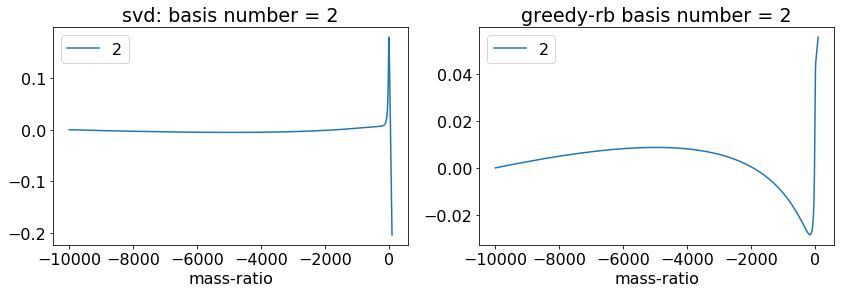

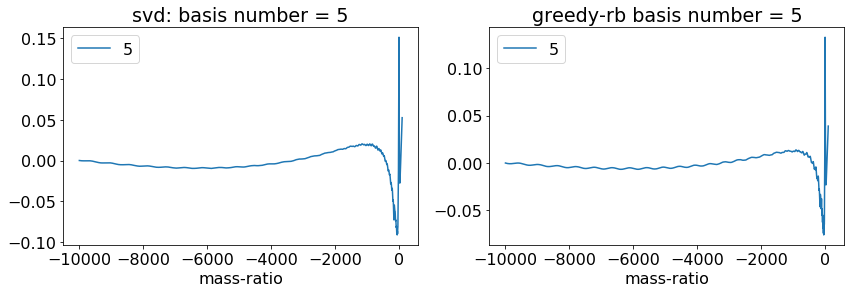

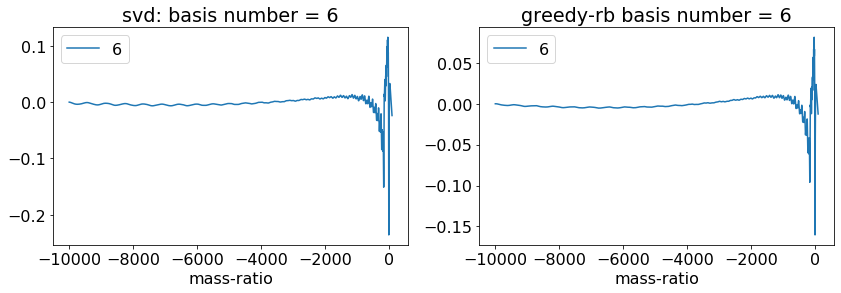

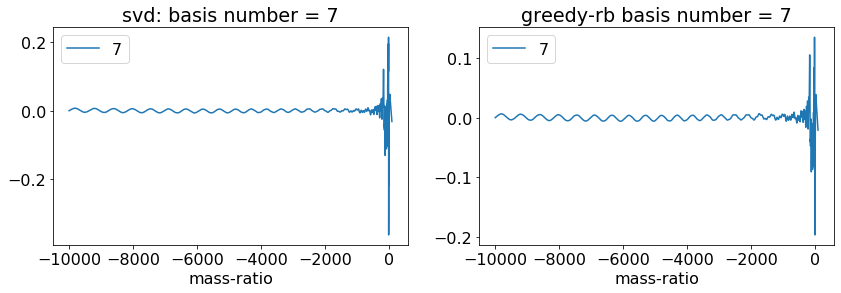

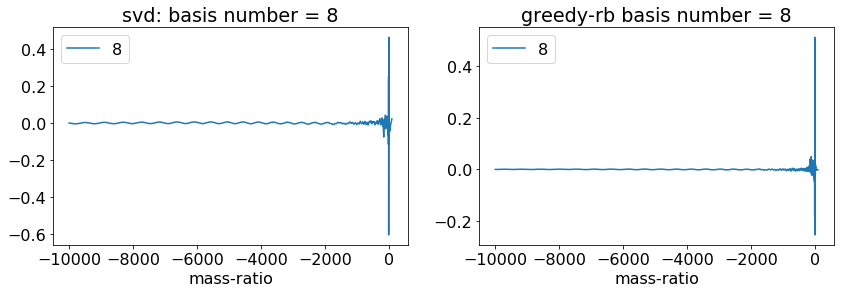

In [40]:
for i in range(basis_size):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].plot(seed_x, vh[i], label=f'{i}')
    axes[0].legend()
    axes[0].set_xlabel("mass-ratio")
    axes[0].set_title(f'svd: basis number = {i}')
    
    axes[1].plot(seed_x, sur.grb.basis[i], label=f'{i}')
    axes[1].legend()
    axes[1].set_xlabel("mass-ratio")
    axes[1].set_title(f'greedy-rb basis number = {i}')
    
    plt.show()
    plt.close()

# comparison between greedy-rb and svd basis coefficients

In [41]:
# the coefficient look quite similar tbh so could pick either one...

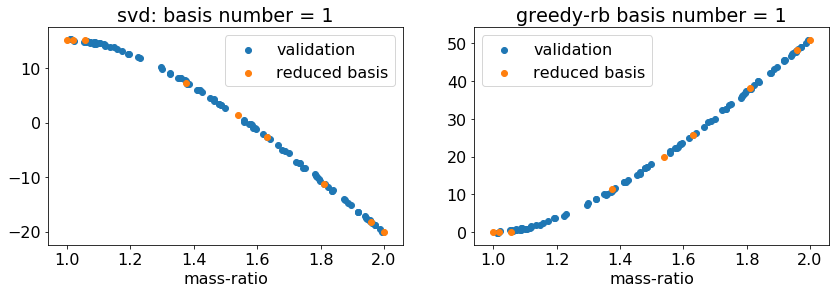

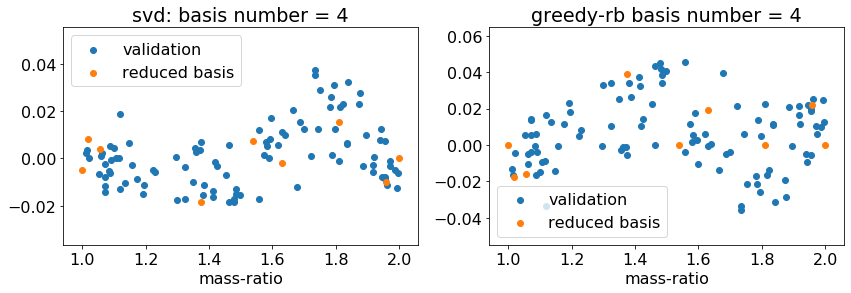

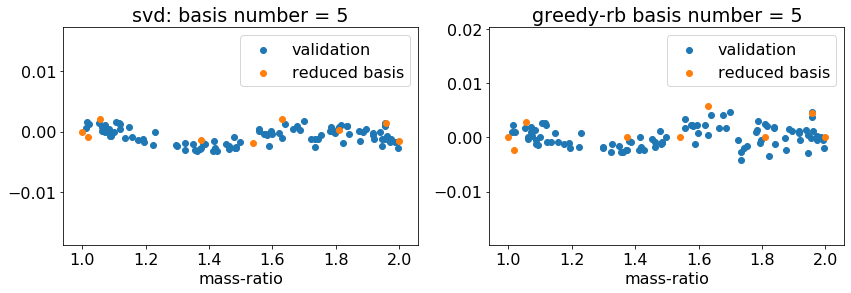

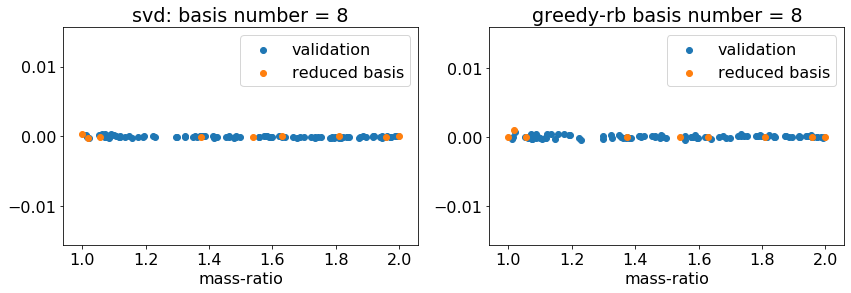

In [42]:
for i in range(proj_coeffs.shape[1]):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    axes[0].scatter(vts_coords[:,0], val_proj_coeffs[:,i], label='validation')
    axes[0].scatter(X[:,0], proj_coeffs[:,i], label='reduced basis')
    axes[0].legend()
    axes[0].set_xlabel("mass-ratio")
    axes[0].set_title(f'svd: basis number = {i}')
    
    axes[1].scatter(vts_coords[:,0], alpha_val[:,i], label='validation')
    axes[1].scatter(X[:,0], alpha_grb[:,i], label='reduced basis')
    axes[1].legend()
    axes[1].set_xlabel("mass-ratio")
    axes[1].set_title(f'greedy-rb basis number = {i}')
    
    plt.show()
    plt.close()

# take the reduced basis coefficients and try and fit them with NN

In [28]:
alpha_val.T.shape

(9, 100)

In [29]:
alpha_grb.shape

(9, 9)


====
training NN
====



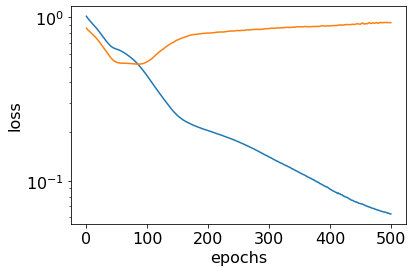

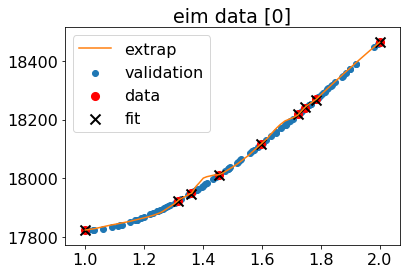

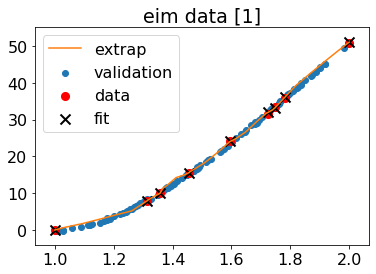

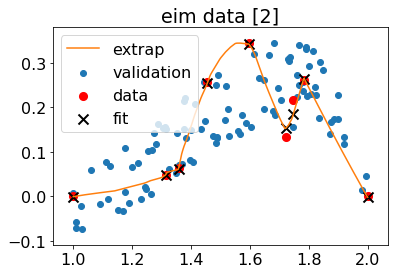

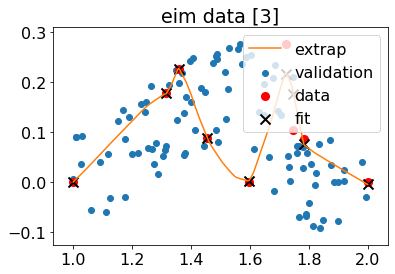

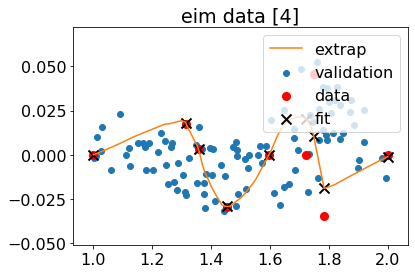

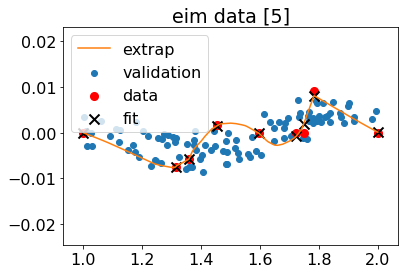

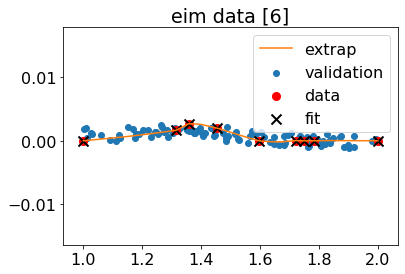

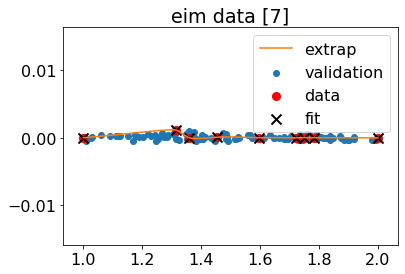

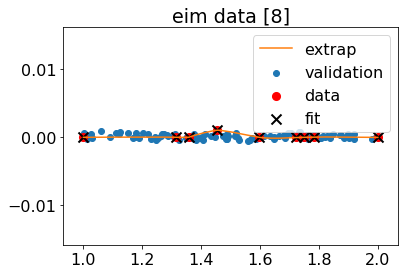

In [30]:
epochs=500
scaleX=True
scaleY=True
X = sur.grb.greedy_points.copy()
X[:,0] = np.log(X[:,0])
y = alpha_grb


Xval = vts_coords.copy()
Xval[:,0] = np.log(Xval[:,0])

validation_data=(Xval, alpha_val)

sur.fit_eim(X, y.T, method='nn', maxdegs=[4], max_deg_total=4, epochs=epochs, scaleX=scaleX, scaleY=scaleY, verbose=True, nn_outname=amp_or_phase + "_best", validation_data=validation_data)

In [31]:
vts_coords[0]

array([1.58671415])

In [32]:
pred1 = sur.predict([vts_coords[0]])

In [33]:
pred1

array([ 0.00000000e+00, -4.90821548e-02, -9.81678594e-02, ...,
       -4.21907014e+02, -4.22995300e+02, -4.24083586e+02])

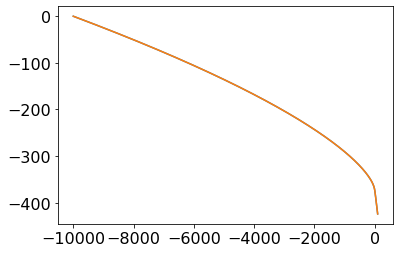

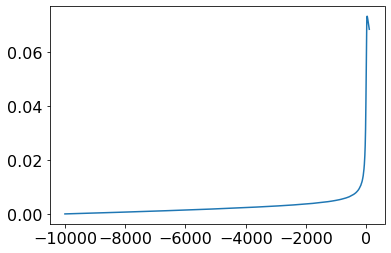

In [34]:
plt.figure()
plt.plot(x, pred1)
plt.plot(x, vts[0])

plt.figure()
plt.plot(x, pred1-vts[0])

In [35]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
worst_error = model_errors[worst_error_index]
print(f"worst error = {worst_error}")
print(f"worst case = {worst_case}")

worst error = 642.6777778503086
worst case = [1.40118126]


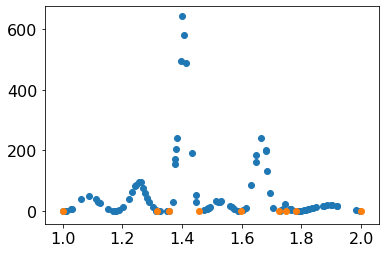

In [36]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

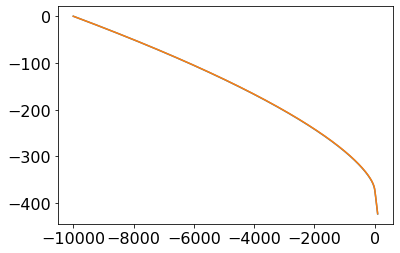

In [41]:
worst_pred = sur.predict([worst_case])

plt.figure()
plt.plot(x, worst_pred)
plt.plot(x, vts[worst_error_index])
plt.show()
plt.close()

plt.figure()
plt.plot(x, worst_pred-vts[worst_error_index])
plt.show()
plt.close()

# add many points to training set

In [42]:
# compute validation points
# check seed basis and add points
_, ts_amp, ts_phase, ext_ts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, 100), mtotal)

if amp_or_phase == "amp":
    ext_ts = ts_amp
elif amp_or_phase == "phase":
    ext_ts = ts_phase


In [43]:
ext_alpha = sur.grb.compute_projection_coefficients_array(sur.grb.basis, ext_ts)

In [44]:
# compute validation points
# check seed basis and add points
_, vts_amp, vts_phase, vts_coords = gen_1d_massratio_data(np.random.uniform(qmin, qmax, 100), mtotal)

if amp_or_phase == "amp":
    vts = vts_amp
elif amp_or_phase == "phase":
    vts = vts_phase
    
alpha_val = sur.grb.compute_projection_coefficients_array(sur.grb.basis, vts)

In [45]:
Xnew = ext_ts_coords.copy()
Xnew[:,0] = np.log(Xnew[:,0])

In [46]:
epochs=500
scaleX=True
scaleY=True

Xfit = np.row_stack((X, Xnew))
yfit = np.row_stack((y, ext_alpha))



In [47]:
Xfit.shape

(109, 1)

In [48]:
yfit.shape

(109, 9)


====
training NN
====



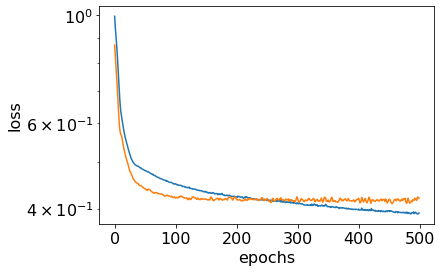

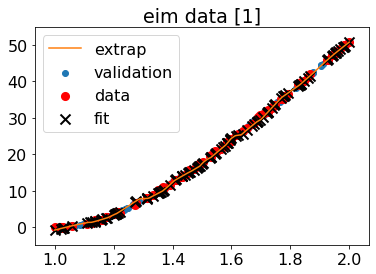

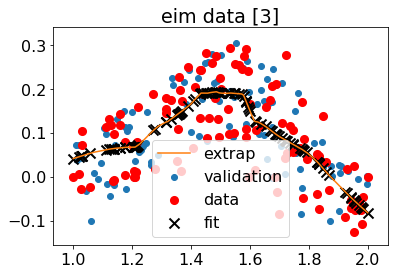

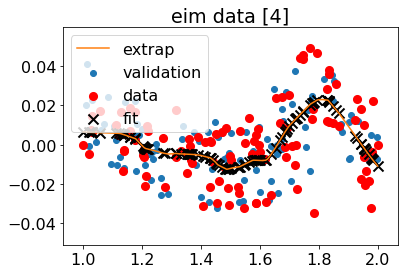

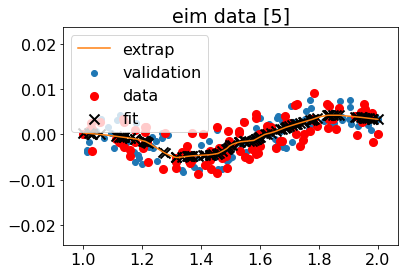

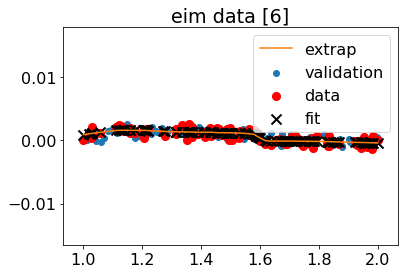

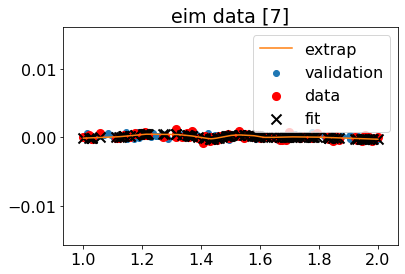

In [50]:
Xval = vts_coords.copy()
Xval[:,0] = np.log(Xval[:,0])

validation_data=(Xval, alpha_val)

sur.fit_eim(Xfit, yfit.T, method='nn', epochs=epochs, scaleX=scaleX, scaleY=scaleY, verbose=True, nn_outname=amp_or_phase + "_best", validation_data=validation_data)

In [51]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
worst_error = model_errors[worst_error_index]
print(f"worst error = {worst_error}")
print(f"worst case = {worst_case}")

worst error = 64.39847650508352
worst case = [1.90385153]


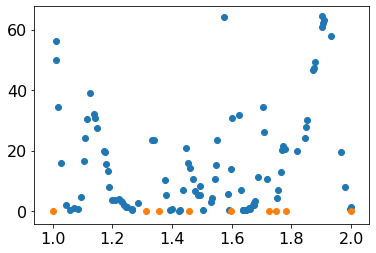

In [52]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

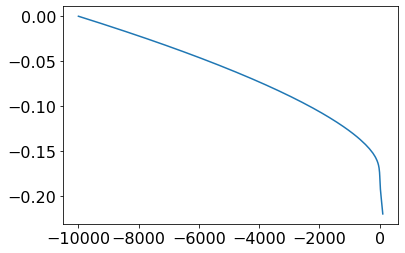

In [53]:
worst_pred = sur.predict([worst_case])

plt.figure()
plt.plot(x, worst_pred)
plt.plot(x, vts[worst_error_index])
plt.show()
plt.close()

plt.figure()
plt.plot(x, worst_pred-vts[worst_error_index])
plt.show()
plt.close()